In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from core.contional_estimator import DCCEstimator
from core.unconditional_estimator import SampleCov, QIS, LS, AO
from core.devolatizer import fit_garch_and_get_std

In [2]:
Total_T = 10000  # 10000 days in total
T = 1000  # 1000 days used, rest 9000 is used for AO
n = 100  # 10 assets
sigma = 0.2  # 20% volatility
dt = 1 / 252  # 1 day
warmup_period = 100

In [3]:
np.random.seed(666)
raw_log_returns = np.random.normal(size=(Total_T, n))
C_root_true = np.random.randn(n, n) * sigma * np.sqrt(dt)
C_true = C_root_true.T @ C_root_true
log_returns = raw_log_returns @ C_root_true.T

In [4]:
R_total = log_returns
R = log_returns[-T:]
D_total = fit_garch_and_get_std(log_returns)
D = D_total[-T:]
S_total = R_total / D_total

In [ ]:
C_sample_cov = SampleCov(R, D).estimate()
C_qis = QIS(R, D).estimate()
C_ls_0 = LS(R, D, rho=0.0).estimate()
C_ls_03 = LS(R, D, rho=0.3).estimate()
C_ls_05 = LS(R, D, rho=0.5).estimate()
C_ao_100 = AO(R, D, lookback_window=100).fit(S_total, n_jobs=8).estimate()
C_ao_200 = AO(R, D, lookback_window=200).fit(S_total, n_jobs=8).estimate()
C_ao_500 = AO(R, D, lookback_window=500).fit(S_total, n_jobs=8).estimate()

Fitting AO model...: 100%|██████████| 9499/9499 [00:10<00:00, 940.07it/s] 


In [7]:
estimate_sample_cov = DCCEstimator(C_sample_cov, R, D).estimate()
estimate_qis = DCCEstimator(C_qis, R, D).estimate()
estimate_ls_0 = DCCEstimator(C_ls_0, R, D).estimate()
estimate_ls_03 = DCCEstimator(C_ls_03, R, D).estimate()
estimate_ls_05 = DCCEstimator(C_ls_05, R, D).estimate()
estimate_ao_100 = DCCEstimator(C_ao_100, R, D).estimate()
estimate_ao_200 = DCCEstimator(C_ao_200, R, D).estimate()
estimate_ao_500 = DCCEstimator(C_ao_500, R, D).estimate()

In [17]:
C_true

array([[ 0.01325569, -0.00163707, -0.00060124, ..., -0.00185765,
        -0.00195164, -0.00039154],
       [-0.00163707,  0.01589482, -0.0015127 , ...,  0.00059347,
        -0.00014512,  0.00025386],
       [-0.00060124, -0.0015127 ,  0.01602522, ...,  0.00047627,
        -0.00159285,  0.00144595],
       ...,
       [-0.00185765,  0.00059347,  0.00047627, ...,  0.01457781,
        -0.00189965,  0.0013465 ],
       [-0.00195164, -0.00014512, -0.00159285, ..., -0.00189965,
         0.01411385, -0.00094611],
       [-0.00039154,  0.00025386,  0.00144595, ...,  0.0013465 ,
        -0.00094611,  0.01392438]], shape=(100, 100))

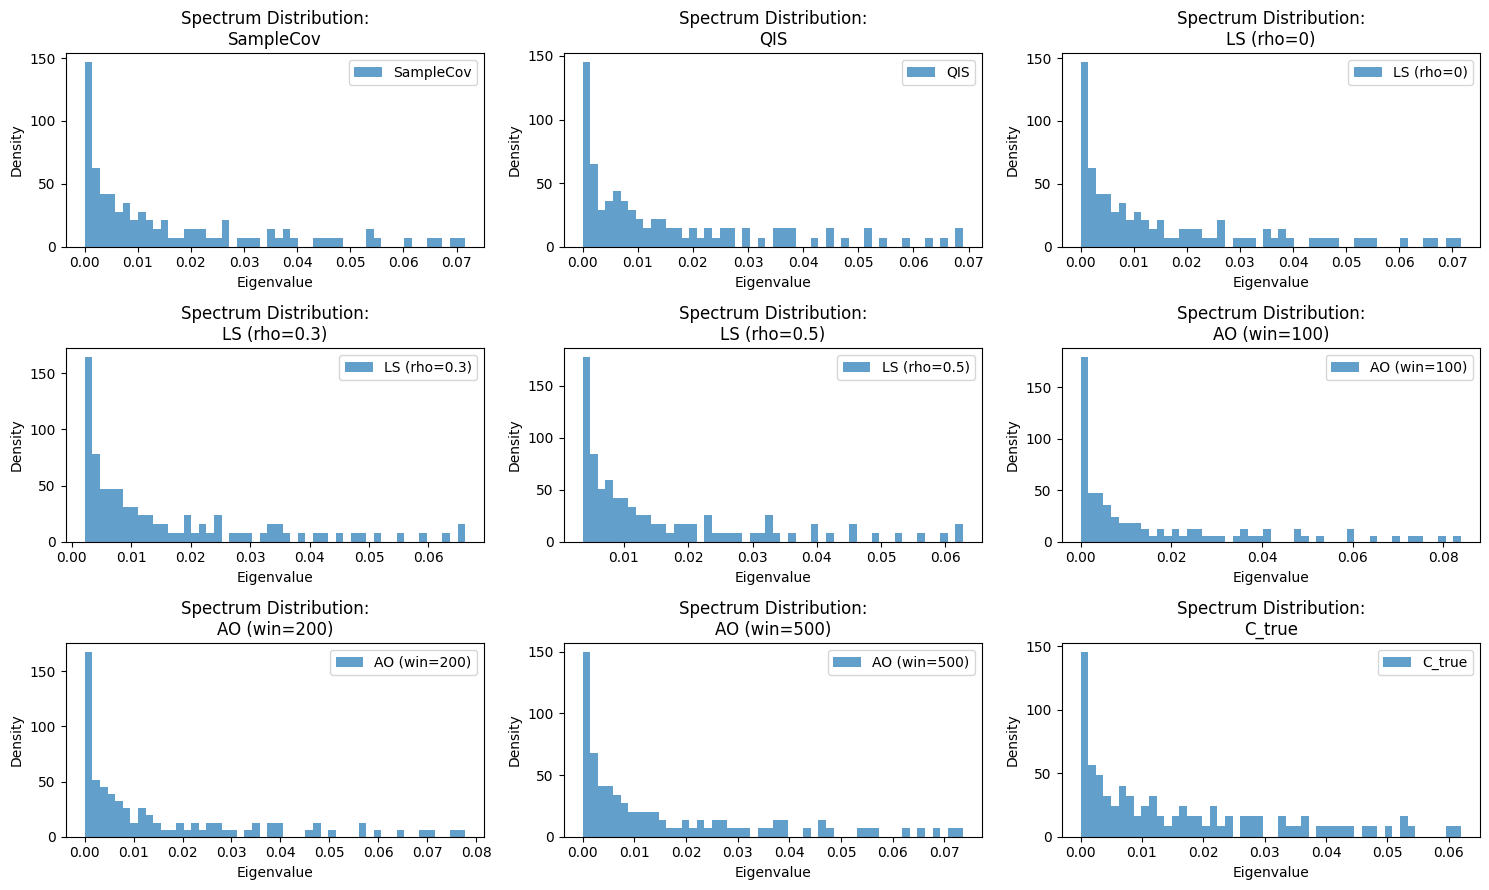

In [18]:
def plot_eigenvalue_hist_grid(cov_list, label_list, bins=50, alpha_list=None):
    n = len(cov_list)
    ncols = 3
    nrows = 3
    _, axes = plt.subplots(nrows, ncols, figsize=(15, 9))
    axes = axes.flatten()

    if alpha_list is None:
        alpha_list = [0.7] * n
    elif len(alpha_list) < n:
        alpha_list = alpha_list + [0.7] * (n - len(alpha_list))

    for i, (cov, label, alpha) in enumerate(zip(cov_list, label_list, alpha_list)):
        eigvals = np.linalg.eigvalsh(cov)
        axes[i].hist(eigvals, bins=bins, density=True, alpha=alpha, label=label)
        axes[i].set_xlabel('Eigenvalue')
        axes[i].set_ylabel('Density')
        axes[i].set_title(f'Spectrum Distribution:\n{label}')
        axes[i].legend()

    # Hide unused subplots if any
    for i in range(n, nrows * ncols):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


cov_list = [
    estimate_sample_cov,
    estimate_qis,
    estimate_ls_0,
    estimate_ls_03,
    estimate_ls_05,
    estimate_ao_100,
    estimate_ao_200,
    estimate_ao_500,
    C_true,
]
label_list = [
    'SampleCov',
    'QIS',
    'LS (rho=0)',
    'LS (rho=0.3)',
    'LS (rho=0.5)',
    'AO (win=100)',
    'AO (win=200)',
    'AO (win=500)',
    'C_true',
]
alpha_list = [0.7] * 8
plot_eigenvalue_hist_grid(cov_list, label_list, bins=50, alpha_list=alpha_list)